### The Nursing Stress Index: A Multimodal Sensor Dataset

Importing the neccesary libraries.

In [27]:
# Import libraries
import pandas as pd
import seaborn as sns
import biosppy.signals as bs
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

### Pre-processing the data

In [3]:
# Load the preprocessed dataset
df = pd.read_csv('m:/pc/My Documents/DSDM/Stress Nurse/merged_data_labeled.csv')

In [4]:
df

,X,Y,Z,EDA,HR,TEMP,id,datetime,label
0,-22,-43,127,21.941885,82.67,36.49,5C,31:00.0,1
1,-22,-44,127,21.949572,82.67,36.49,5C,31:00.2,1
2,-22,-44,127,21.977753,82.67,36.49,5C,31:00.5,1
3,-22,-43,127,21.988001,82.67,36.49,5C,31:00.7,1
4,-22,-44,127,21.984158,82.67,36.50,5C,31:01.0,1
...,...,...,...,...,...,...,...,...,...
1048570,-5,-59,40,0.101213,104.27,29.29,DF,55:08.7,2
1048571,-82,-31,12,0.106338,103.83,29.29,DF,55:09.0,2
1048572,1,-46,49,0.107619,103.83,29.29,DF,55:09.2,2
1048573,-25,-58,13,0.108900,103.83,29.29,DF,55:09.5,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   X         1048575 non-null  int64  
 1   Y         1048575 non-null  int64  
 2   Z         1048575 non-null  int64  
 3   EDA       1048575 non-null  float64
 4   HR        1048575 non-null  float64
 5   TEMP      1048575 non-null  float64
 6   id        1048575 non-null  object 
 7   datetime  1048575 non-null  object 
 8   label     1048575 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 72.0+ MB


For this dataset, we load the data from the merged data CSV file into a pandas DataFrame, and then use the isnull() method to check for missing values. The sum() method is used to count the number of missing values for each column.

In [8]:
# Check for missing values
print('Number of missing values:')
print(df.isnull().sum())

Number of missing values:
X           0
Y           0
Z           0
EDA         0
HR          0
TEMP        0
id          0
datetime    0
label       0
dtype: int64


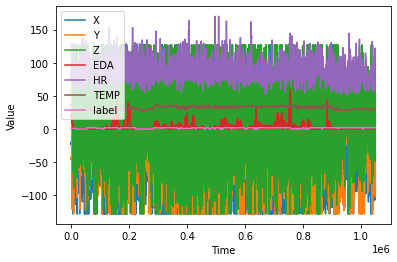

In [6]:
ax = df.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Value')
# Set the x-axis limits to a particular time range
# Show the plot
plt.show()

Extracted features from Electrodermal Activity (EDA), Skin Temperature, and Heart Rate (HR) signals in a sliding window approach. The signal data is first split into sliding windows of a fixed size (10 seconds) and a step size of 5 seconds. Then, for each window, you extracted features from each signal using the BioSPPy package.

For EDA, we then extract the mean, minimum, maximum, skewness, kurtosis, and the number of peaks. For skin temperature, we extracted the mean, minimum, maximum, skewness, and kurtosis. For HR, we extracted the mean, minimum, maximum, skewness, kurtosis, and the number of peaks.

The extracted features are then added to the respective feature lists: eda_features, temp_features, and hr_features. The reason for this feature extraction is to obtain relevant and useful information from the signals that can be used for modeling, to predict the stress levels of the nurses.

In [5]:
import scipy
# Defining the sliding window
window_size = 10 * 1000  # 10 seconds in milliseconds
step_size = 5 * 1000  # 5 seconds in milliseconds

# Initializing the feature list
eda_features = []
temp_features = []
hr_features = []

# Iterating over sliding windows
for i in range(0, len(df), step_size):
    # Extracting signal data for current window
    eda_signal = df['EDA'][i:i+window_size]
    temp_signal = df['TEMP'][i:i+window_size]
    hr_signal = df['HR'][i:i+window_size]
    
    # Extracting features from EDA signal
    eda_feats = bs.eda.eda(signal=eda_signal, sampling_rate=1000, show=False)
    eda_mean = np.mean(eda_feats[0])
    eda_min = np.min(eda_feats[0])
    eda_max = np.max(eda_feats[0])
    eda_skewness = eda_feats[3]
    eda_kurtosis = eda_feats[4]
    eda_num_peaks = len(eda_feats[2])
    
    # Extracting features from skin temperature signal
    temp_mean = np.mean(temp_signal)
    temp_min = np.min(temp_signal)
    temp_max = np.max(temp_signal)
    temp_skewness = scipy.stats.skew(temp_signal)
    temp_kurtosis = scipy.stats.kurtosis(temp_signal)
    
    # Extracting features from Heart Rate signal
    hr_feats = bs.ecg.ecg(signal=hr_signal, sampling_rate=1000, show=False)
    hr_mean = np.mean(hr_feats[0])
    hr_min = np.min(hr_feats[0])
    hr_max = np.max(hr_feats[0])
    hr_skewness = hr_feats[3]
    hr_kurtosis = hr_feats[4]
    hr_num_peaks = len(hr_feats[2])
    
    # Adding features to the lists
    eda_features.append([eda_mean, eda_min, eda_max, eda_skewness, eda_kurtosis, eda_num_peaks])
    temp_features.append([temp_mean, temp_min, temp_max, temp_skewness, temp_kurtosis])
    hr_features.append([hr_mean, hr_min, hr_max, hr_skewness, hr_kurtosis, hr_num_peaks])

The extracted features from Electrodermal Activity (EDA), Skin Temperature, and Heart Rate (HR) signals are combined into a single feature matrix for each sliding window. It then initializes an empty list called combined_features and iterates over the length of eda_features.

The features are then extracted from each signal for the current window are concatenated to create the curr_features list. If i is greater than 2, the features from the previous three windows are also concatenated to the curr_features list.

Finally, the curr_features list is appended to the combined_features list. The purpose of concatenating the features from multiple windows is to provide a more comprehensive representation of the nurse's physiological state over time, rather than just the features from a single window. By concatenating the features from multiple windows, a better overall view of the nurse's physiological state can be obtained over a period of time, as to relying on features from just one window.

In [28]:
# Combine features from current and previous windows
combined_features = []
for i in range(len(eda_features)):
    curr_features = eda_features[i] + temp_features[i] + hr_features[i]
    if i > 2:
        prev_features = eda_features[i-1] + temp_features[i-1] + hr_features[i-1]
        prev2_features = eda_features[i-2] + temp_features[i-2] + hr_features[i-2]
        prev3_features = eda_features[i-3] + temp_features[i-3] + hr_features[i-3]
        combined_features.append(curr_features + prev_features + prev2_features + prev3_features)
    else:
        combined_features.append(curr_features)

### Summary Statistics of Each Signal

In [29]:
features_EDA = {
    "EDA_mean": eda_mean,
    "EDA_min": eda_min,
    "EDA_max": eda_max,
    "EDA_skewness": eda_skewness,
    "EDA_kurtosis": eda_kurtosis,
    "EDA_peaks": eda_num_peaks}

df_features_EDA = pd.DataFrame(features_EDA)
print(df_features_EDA.head())

   EDA_mean  EDA_min  EDA_max  EDA_skewness  EDA_kurtosis  EDA_peaks
0     1.787      0.0    3.574          1325      0.005338          1


In [8]:
features_TEMP = {
    "SkinTemp_mean": temp_mean,
    "SkinTemp_min": temp_min,
    "SkinTemp_max": temp_max,
    "SkinTemp_skewness": temp_skewness,
    "SkinTemp_kurtosis": temp_kurtosis,}

df_features_TEMP = pd.DataFrame(features_TEMP, index=[0])
print(df_features_TEMP.head())

   SkinTemp_mean  SkinTemp_min  SkinTemp_max  SkinTemp_skewness  \
0      29.354006         29.15         29.59           0.000572   

   SkinTemp_kurtosis  
0          -0.610555  


In [9]:
hr_kurt_1d = np.mean(hr_kurtosis, axis=0)
features_HR = {"HR_mean": hr_mean,
    "HR_min": hr_min,
    "HR_max": hr_max,
    "HR_skewness": hr_skewness,
    "HR_kurtosis": hr_kurt_1d,
    }

df_features_HR = pd.DataFrame(features_HR)
print(df_features_HR.head())

   HR_mean  HR_min  HR_max  HR_skewness  HR_kurtosis
0    1.787     0.0   3.574       -0.200     3.805293
1    1.787     0.0   3.574       -0.199     3.803825
2    1.787     0.0   3.574       -0.198     3.801447
3    1.787     0.0   3.574       -0.197     3.798228
4    1.787     0.0   3.574       -0.196     3.794250


In [10]:
df_features = pd.concat([df_features_EDA, df_features_TEMP, df_features_HR], axis=1)
print(df_features.head())

   EDA_mean  EDA_min  EDA_max  EDA_skewness  EDA_kurtosis  EDA_peaks  \
0     1.787      0.0    3.574        1325.0      0.005338        1.0   
1       NaN      NaN      NaN           NaN           NaN        NaN   
2       NaN      NaN      NaN           NaN           NaN        NaN   
3       NaN      NaN      NaN           NaN           NaN        NaN   
4       NaN      NaN      NaN           NaN           NaN        NaN   

   SkinTemp_mean  SkinTemp_min  SkinTemp_max  SkinTemp_skewness  \
0      29.354006         29.15         29.59           0.000572   
1            NaN           NaN           NaN                NaN   
2            NaN           NaN           NaN                NaN   
3            NaN           NaN           NaN                NaN   
4            NaN           NaN           NaN                NaN   

   SkinTemp_kurtosis  HR_mean  HR_min  HR_max  HR_skewness  HR_kurtosis  
0          -0.610555    1.787     0.0   3.574       -0.200     3.805293  
1               

The stress level of the nurse is determined based on the Heart Rate (HR) mean feature values. Thresholds are defined for low stress and high stress levels. Stress_level is added to the feature dataframe to hold the labels.

The stress level is set based on the HR_mean feature values by using the loc function to set the stress level column to 2 if the HR_mean value is greater than or equal to the high stress threshold, 1 if the HR_mean value is between the low stress and high stress thresholds, and 0 if the HR_mean value is less than the low stress threshold.

In [11]:
# define thresholds for stress levels based on feature values
low_stress_threshold = 0.5
high_stress_threshold = 0.8

# create a new column in the feature dataframe to hold the labels
df_features_HR['stress_level'] = 0

# Set the stress level based on feature values
df_features_HR.loc[df_features_HR['HR_mean'] >= high_stress_threshold, 'stress_level'] = 2
df_features_HR.loc[(df_features_HR['HR_mean'] >= low_stress_threshold) & (df_features_HR['HR_mean'] < high_stress_threshold), 'stress_level'] = 1
df_features_HR.loc[df_features_HR['HR_mean'] < low_stress_threshold, 'stress_level'] = 0

# get the labels as a separate dataframe
df_labels = df_features_HR[['stress_level']]

In [12]:
df_labels.head()

,stress_level
0,2
1,2
2,2
3,2
4,2


After combining the features of Heart Rate which has the mean, min, max and skewness with the Stress Levels.

Using correlation matrix, we then find and visualise the the correlation between HR features and Stress Levels.

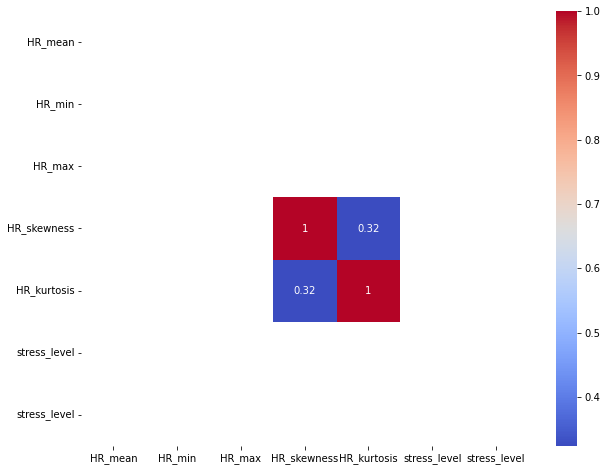

In [17]:
#Combine the features and labels into a single df
df_combined = pd.concat([df_features_HR, df_labels], axis=1)

#Finding the correlation matrix
corr_matrix = df_combined.corr()
plt.figure(figsize=(10, 8))

#Visualizing the correlation matrix 
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()


In [18]:
df_features.fillna(0, inplace=True)

In [19]:
df_labels['stress_level'].replace({0: 'No stress', 1: 'Medium stress', 2: 'High stress'}, inplace=True)

In [20]:
df_labels

,stress_level
0,High stress
1,High stress
2,High stress
3,High stress
4,High stress
...,...
595,High stress
596,High stress
597,High stress
598,High stress


### Model Building

Built a Random Forest classifier model to predict stress levels based on the features extracted from the dataset.

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


X = df_features.values 
y = df_labels['stress_level'].values # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid : search over
param_grid = {
    'n_estimators': [300, 400, 500, 700, 1000],
    'min_samples_leaf': [3, 4, 5, 6, 7],
    'max_depth': [10, 12, 15, 18, 20],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Building the Random Forest classifier and perform grid search to find the best hyperparameters
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=10)
grid_search.fit(X_train, y_train)

# Print
print("Best hyperparameters:", grid_search.best_params_)
print("Accuracy on test set:", grid_search.score(X_test, y_test))


Best hyperparameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 300}
Accuracy on test set: 1.0


### Plotting 

Going ahead, by computing the average EDA for each participant, we visualise the Stress levels with the EDA for every participant. Same goes with using Heart Rate.

<AxesSubplot:xlabel='id', ylabel='EDA'>

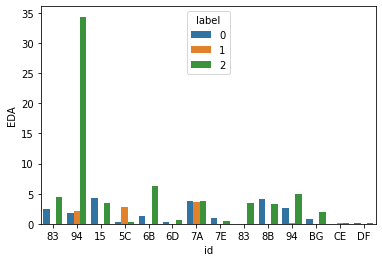

In [27]:
# Compute the average EDA for each participant and stress level
df_eda = df.groupby(['id', 'label'])['EDA'].mean().reset_index()

# Plot the bar plot
sns.barplot(x='id', y='EDA', hue='label', data=df_eda)
# Where 0 is No stress, 1 is Medium Stress, 2 is high stress where id is the participants. 

<AxesSubplot:xlabel='id', ylabel='HR'>

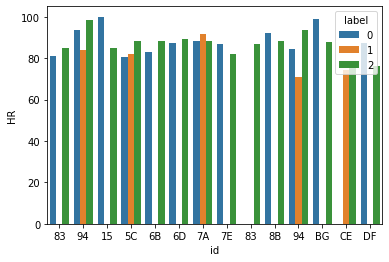

In [26]:
# Compute the average HR for each participant and stress level
df_hr = df.groupby(['id', 'label'])['HR'].mean().reset_index()

sns.barplot(x='id', y='HR', hue='label', data=df_hr)
# Where 0 is No stress, 1 is Medium Stress, 2 is high stress where id is the participants. 

### Change Point Detection

A sliding window approach is used to detect change points in the physiological signals.

For each window, the EDA, skin temperature, and heart rate signals are extracted, and features are calculated for each signal. The features are then concatenated with the features from the previous window, if any, to provide a more detailed state of the nurses state.

The CUSUM algorithm is then used to detect change points in the concatenated features. The threshold and drift parameters are set to control the sensitivity and specificity of the change point detection.

If a change point is detected, the current window index is added to the change_points list.

In [13]:
# Sliding window parameters
window_size = 10 * 1000  # 10 seconds in milliseconds
step_size = 5 * 1000  # 5 seconds in milliseconds

# Initialize feature list and change point list
eda_features = []
temp_features = []
hr_features = []
change_points = []

# Initialize CUSUM algorithm parameters
threshold = 50  # threshold for change detection
drift = 10  # drift parameter for change detection

# Initialize CUSUM algorithm variables
s = 0
m = 0

# Iterating the sliding windows
for i in range(0, len(df), step_size):
    # Extracting the signal data for current window
    eda_signal = df['EDA'][i:i+window_size]
    temp_signal = df['TEMP'][i:i+window_size]
    hr_signal = df['HR'][i:i+window_size]
    
    # Extracting the features from EDA 
    eda_feats = bs.eda.eda(signal=eda_signal, sampling_rate=1000, show=False)
    eda_mean = np.mean(eda_feats[0])
    
    # Extracting features from skin temperature
    temp_mean = np.mean(temp_signal)
    
    # Extracting features from Heart Rate 
    hr_feats = bs.ecg.ecg(signal=hr_signal, sampling_rate=1000, show=False)
    hr_mean = np.mean(hr_feats[0])
    
    # Combining the features from current and previous windows
    curr_features = [eda_mean, temp_mean, hr_mean]
    if len(eda_features) > 0:
        prev_features = eda_features[-1] + temp_features[-1] + hr_features[-1]
        combined_features = curr_features + prev_features
    else:
        combined_features = curr_features
    
    # Add the features to the lists
    eda_features.append([eda_mean])
    temp_features.append([temp_mean])
    hr_features.append([hr_mean])
    
    # CUSUM algorithm variables
    s += combined_features[0] - m - threshold
    m += drift * np.sign(s)
    
    # Check for change point
    if s > 0:
        change_points.append(i)
        s = 0
        m = 0

print("Detected change points at: ", change_points)


Detected change points at:  [50000, 105000, 160000, 215000, 270000, 325000, 380000, 435000, 490000, 545000, 600000, 655000, 710000, 765000, 820000, 875000, 930000, 985000, 1040000]


A line plot of the signals  which is EDA, temperature, and heart rate with vertical red lines indicating the detected change points based on the CUSUM algorithm applied in the previous code. 

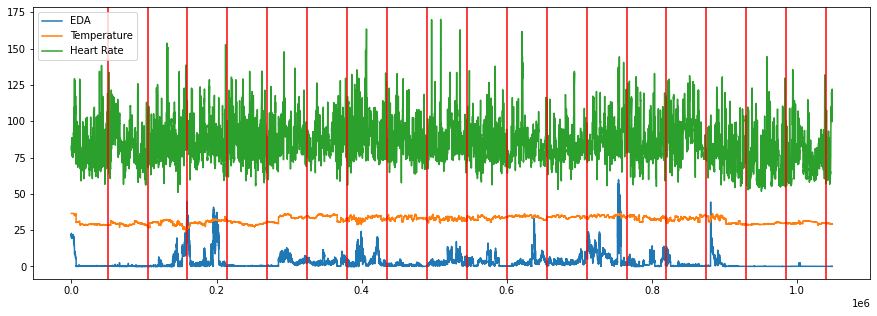

In [15]:
# Plotting the signals and change points
plt.figure(figsize=(15, 5))
plt.plot(df.index, df['EDA'], label="EDA")
plt.plot(df.index, df['TEMP'], label="Temperature")
plt.plot(df.index, df['HR'], label="Heart Rate")
for point in change_points:
    plt.axvline(x=point, color='r')
plt.legend()
plt.show()